<a href="https://colab.research.google.com/github/AnoshkinDV/Analysis-Data/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22stock_market_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Прогнозирование цен акций с использованием нейронных сетей**

In [20]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [63]:
import time

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

100%|██████████| 492M/492M [00:03<00:00, 139MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
df = pd.read_csv("/root/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3/Stocks/aapl.us.txt")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [32]:
df.shape

(8364, 7)

In [33]:
df.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [34]:
df["Date"].min(), df["Date"].max()

('1984-09-07', '2017-11-10')

<Axes: xlabel='Date'>

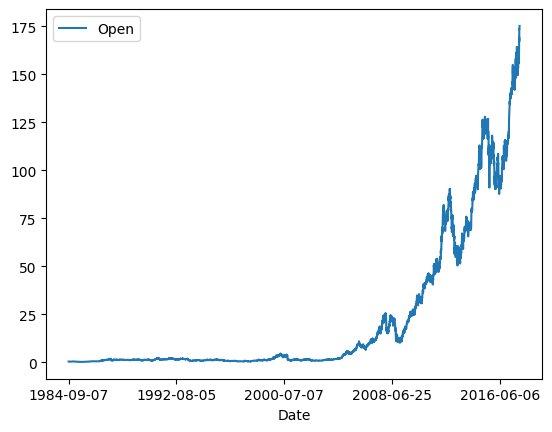

In [16]:
df.plot(x="Date", y="Open")

<Axes: xlabel='Date'>

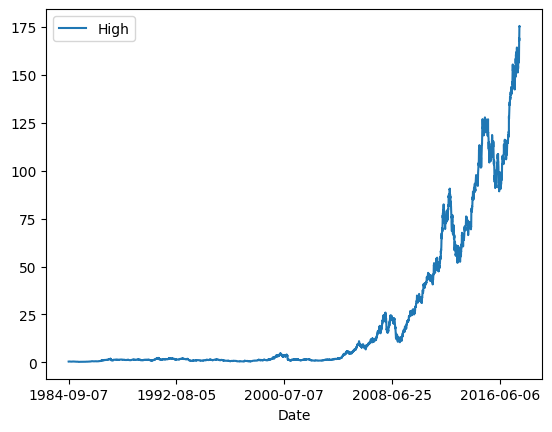

In [17]:
df.plot(x="Date", y="High")

In [18]:
df[["Open", "Close", "Low", "High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [38]:
df_6_yr = df[df['Date'] > df['Date'].max() - timedelta(days = 6 * 365)]

In [39]:
df['Date'] = pd.to_datetime(df['Date'])

In [36]:
print(df.dtypes)

Date       datetime64[ns]
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
OpenInt             int64
dtype: object


In [40]:
df_6_yr["Date"].min(), df_6_yr["Date"].max()

(Timestamp('2011-11-14 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [42]:
df_6_yr.shape

(1509, 7)

In [41]:
train_size = int(df_6_yr.shape[0] * 0.8)
print(train_size)
train_df = df_6_yr.iloc[:train_size]
train_df.tail(5)
val_df = df_6_yr.iloc[train_size:]
val_df.tail(5)

1207


,Date,Open,High,Low,Close,Volume,OpenInt
8359,2017-11-06,171.75,174.36,171.10,173.63,34901241,0
8360,2017-11-07,173.29,174.51,173.29,174.18,24424877,0
8361,2017-11-08,174.03,175.61,173.71,175.61,24451166,0
8362,2017-11-09,174.48,175.46,172.52,175.25,29533086,0
8363,2017-11-10,175.11,175.38,174.27,174.67,25130494,0


In [43]:
train_df.shape, val_df.shape

((1207, 7), (302, 7))

In [44]:
train_df["Date"].min(), train_df["Date"].max(), val_df["Date"].min(), val_df["Date"].max()

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

In [46]:
scaler = StandardScaler()
scaler.fit(train_df[["Low"]])

def make_dataset(
    df,
     window_size,
     batch_size,
     use_scaler=True,
     shuffle=True
     ):
  features = df[["Low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["Low"].iloc[window_size:],
      sequence_length=window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size)
  return ds

In [47]:
example_ds = make_dataset(df=train_df, window_size=3, batch_size=2, use_scaler=False, shuffle=False)

In [48]:
example_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [49]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [50]:
example_feature.shape


(2, 3, 1)

In [51]:
example_label.shape


(2,)

In [52]:
train_df["Low"].iloc[:6]

,Low
6855,48.432
6856,48.592
6857,49.217
6858,48.086
6859,48.009
6860,46.860


In [53]:
print(example_feature[0])
print(example_label[0])

[[48.432]
 [48.592]
 [49.217]]
48.086


In [54]:
print(example_feature[1])
print(example_label[1])

[[48.592]
 [49.217]
 [48.086]]
48.009


In [58]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [59]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [93]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20, early_stopping = None):
  model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
  history = model.fit(
      train_ds,
      epochs=num_epochs,
      validation_data=val_ds,
      verbose=0,
      callbacks=[early_stopping] if early_stopping is not None else []
      )
  return history

In [64]:
start_time = time.time()  # фиксируем начало обучения
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)
end_time = time.time()  # фиксируем окончание обучения
elapsed_time_sec = end_time - start_time
print(f"Обучение заняло {elapsed_time_sec:.2f} секунд")
print(f"Или примерно {elapsed_time_sec / 60:.2f} минут")

Обучение заняло 136.64 секунд
Или примерно 2.28 минут


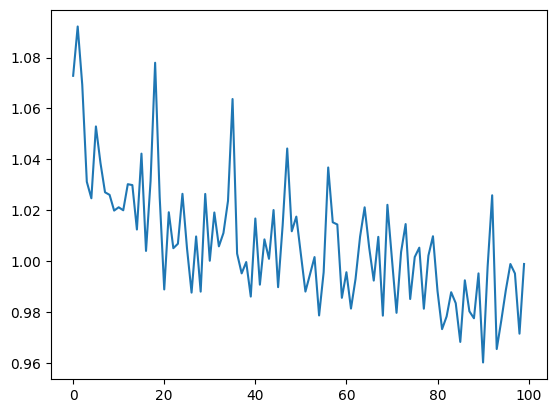

In [65]:
plt.plot(history.history['mean_absolute_error'])

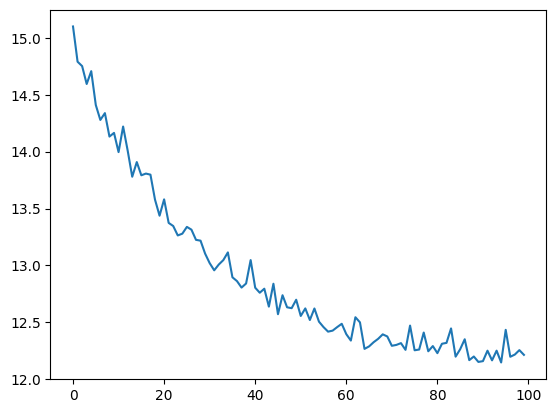

In [66]:
plt.plot(history.history['val_mean_absolute_error'])

In [71]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [72]:
start_time = time.time()  # фиксируем начало обучения
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500)
end_time = time.time()  # фиксируем окончание обучения
elapsed_time_sec = end_time - start_time
print(f"Обучение заняло {elapsed_time_sec:.2f} секунд")
print(f"Или примерно {elapsed_time_sec / 60:.2f} минут")

Обучение заняло 677.96 секунд
Или примерно 11.30 минут


In [73]:
lstm_model.evaluate(train_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5396 - mean_absolute_error: 1.2651


[2.8526039123535156, 1.2962757349014282]

In [74]:
lstm_model.evaluate(val_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.6918 - mean_absolute_error: 5.0420


[48.827945709228516, 5.243814945220947]

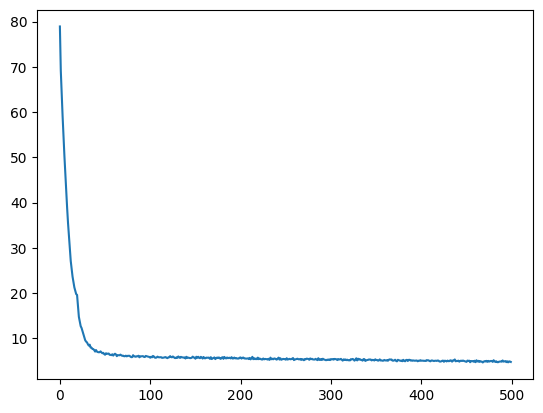

In [75]:
plt.plot(history.history['mean_absolute_error'])

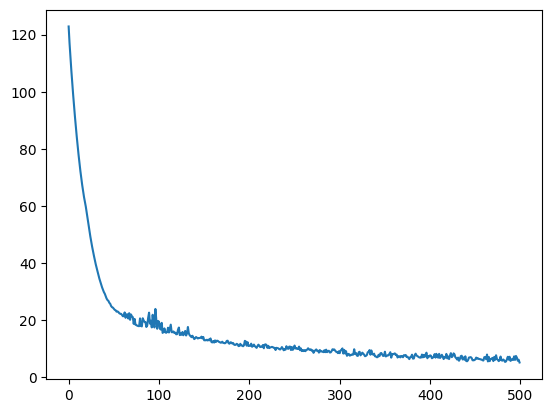

In [76]:
plt.plot(history.history['val_mean_absolute_error'])

Добавим L2 регуляризацию

In [77]:
from tensorflow.keras import regularizers

In [102]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False,kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,kernel_regularizer=regularizers.l2(0.001))
])

In [101]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=15,  # сколько эпох ждать улучшения
    restore_best_weights=True
)

In [103]:
start_time = time.time()  # фиксируем начало обучения
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500, early_stopping=early_stopping)
end_time = time.time()  # фиксируем окончание обучения
elapsed_time_sec = end_time - start_time
print(f"Обучение заняло {elapsed_time_sec:.2f} секунд")
print(f"Или примерно {elapsed_time_sec / 60:.2f} минут")

Обучение заняло 317.84 секунд
Или примерно 5.30 минут


In [104]:
lstm_model.evaluate(train_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8744 - mean_absolute_error: 1.1324


[3.143538236618042, 1.1545259952545166]

In [105]:
lstm_model.evaluate(val_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 139.4289 - mean_absolute_error: 8.6019


[140.42626953125, 8.917686462402344]

In [99]:
lstm_model.evaluate(train_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.3153 - mean_absolute_error: 1.9879


[10.612194061279297, 2.017859697341919]

In [100]:
lstm_model.evaluate(val_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 469.1102 - mean_absolute_error: 17.4049


[458.313232421875, 17.093658447265625]